<a href="https://colab.research.google.com/github/rajlm10/D2L-Torch/blob/main/D2L_SNLI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l -q 

     |████████████████████████████████| 82 kB 271 kB/s 
     |████████████████████████████████| 61 kB 5.9 MB/s 
     |████████████████████████████████| 9.9 MB 21.7 MB/s 
     |████████████████████████████████| 15.7 MB 48.6 MB/s 
     |████████████████████████████████| 11.2 MB 28.4 MB/s 
     |████████████████████████████████| 930 kB 55.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [28]:
!pip install -q torchinfo

In [29]:
import os
import re
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import nltk
import collections
import multiprocessing
from torchinfo import summary
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
d2l.DATA_HUB['SNLI'] = ( 'https://nlp.stanford.edu/projects/snli/snli_1.0.zip', '9fcde07509c7e87ec61c640c1b2753d9041758e4')
data_dir = d2l.download_extract('SNLI')

#Creating the dataset

In [5]:
class Vocab:
  def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
    if tokens is None:
      tokens = []
    if reserved_tokens is None: 
      reserved_tokens = []
    # Sort according to frequencies
    counter = count_corpus(tokens)
    self._token_freqs = sorted(counter.items(), key=lambda x: x[1],reverse=True)

    #Build vocab on init
    self.idx_to_token=['<unk>']+reserved_tokens #List
    self.token_to_idx={token:idx for idx,token in enumerate(self.idx_to_token)} #Dict

    for token,freq in self._token_freqs:
      #Don't include tokens with freq<min_freq in the vocab
      if freq<min_freq:
        break
      if token not in self.idx_to_token:
        self.idx_to_token.append(token)
        self.token_to_idx[token]=len(self.idx_to_token)-1

  def __len__(self):
    return len(self.idx_to_token)

  @property
  def unk(self):
    # Index for the unknown token
    return 0
  
  @property
  def token_freqs(self):
    # Counter object 
    return self._token_freqs
  
  def __getitem__(self,tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.token_to_idx.get(tokens, self.unk) 
    #If tokens is a list 
    return [self.__getitem__(token) for token in tokens]

  def to_tokens(self, indices):
    if not isinstance(indices, (list, tuple)):
      return self.idx_to_token[indices]
    #If indices is a list
    return [self.idx_to_token[index] for index in indices]


def count_corpus(tokens):
  """Count token frequencies."""
  # Here `tokens` is a 1D list or 2D list
  if len(tokens) == 0 or isinstance(tokens[0], list):
    # Flatten a list of token lists into a 1D list
    tokens = [token for line in tokens for token in line]
  #If its already a 1D list,return  
  return collections.Counter(tokens)

In [7]:
def truncate_pad(line, num_steps, padding_token):
  """Truncate or pad sequences."""
  #Line is a list of tokens
  if len(line) > num_steps:
    return line[:num_steps] # Truncate
  return line + [padding_token] * (num_steps - len(line)) # Pad

In [3]:
def read_snli(data_dir, is_train):
  """Read the SNLI dataset into premises, hypotheses, and labels.""" 
  def extract_text(s):
    # Remove information that will not be used by us
    s = re.sub('\\(', '', s)
    s = re.sub('\\)', '', s)
    # Substitute two or more consecutive whitespace with space 
    s = re.sub('\\s{2,}', ' ', s)
    return s.strip()

  label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2} 
  file_name = os.path.join(data_dir, 'snli_1.0_train.txt' if is_train else 'snli_1.0_test.txt') 
  
  with open(file_name, 'r') as f:
    rows = [row.split('\t') for row in f.readlines()[1:]]
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set] 
    hypotheses = [extract_text(row[2]) for row in rows if row[0] in label_set] 
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
  return premises, hypotheses, labels

In [ ]:
train_data = read_snli(data_dir, is_train=True)
train_tokens=[nltk.tokenize.word_tokenize(sentence_1 + " " + sentence_2) for sentence_1,sentence_2 in zip(train_data[0],train_data[1])]


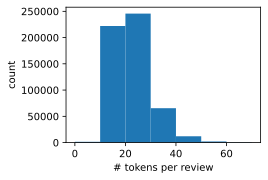

In [17]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 80, 10));

In [8]:
class SNLIDataset(torch.utils.data.Dataset):
  """A customized dataset to load the SNLI dataset.""" 
  def __init__(self, dataset, num_steps, vocab=None):
    self.num_steps = num_steps
    all_premise_tokens = [nltk.tokenize.word_tokenize(sentence) for sentence in dataset[0]] 
    all_hypothesis_tokens = [nltk.tokenize.word_tokenize(sentence) for sentence in dataset[1]] 
    
    if vocab is None:
      self.vocab = d2l.Vocab(all_premise_tokens + all_hypothesis_tokens, min_freq=5, reserved_tokens=['<pad>'])
    else:
      self.vocab = vocab
    self.premises = self._pad(all_premise_tokens) 
    self.hypotheses = self._pad(all_hypothesis_tokens) 
    self.labels = torch.tensor(dataset[2])
    print('read ' + str(len(self.premises)) + ' examples')
  
  def _pad(self, lines):
    return torch.tensor([d2l.truncate_pad(self.vocab[line], self.num_steps, self.vocab['<pad>']) for line in lines])
  
  def __getitem__(self, idx):
    return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]
  
  def __len__(self):
    return len(self.premises)

In [10]:
def load_data_snli(batch_size, num_steps=50):
  """Download the SNLI dataset and return data iterators and vocabulary.""" 
  num_workers = multiprocessing.cpu_count()
  data_dir = d2l.download_extract('SNLI')
  train_data = read_snli(data_dir, True)
  test_data = read_snli(data_dir, False)
  train_set = SNLIDataset(train_data, num_steps)
  test_set = SNLIDataset(test_data, num_steps, train_set.vocab)
  train_iter = torch.utils.data.DataLoader(train_set, batch_size,shuffle=True,num_workers=num_workers) 
  test_iter = torch.utils.data.DataLoader(test_set, batch_size,shuffle=False,num_workers=num_workers) 
  return train_iter, test_iter, train_set.vocab

In [18]:
train_iter, test_iter, vocab = load_data_snli(128, 64) 
len(vocab)

read 549367 examples
read 9824 examples


18676

In [36]:
for X, Y in train_iter: 
  print(X[0].shape,type(X[0]),X[0][0].shape,type(X[0][0])) 
  print(X[1].shape) 
  print(Y.shape) 
  break

torch.Size([128, 64]) <class 'torch.Tensor'> torch.Size([64]) <class 'torch.Tensor'>
torch.Size([128, 64])
torch.Size([128])


# The Model

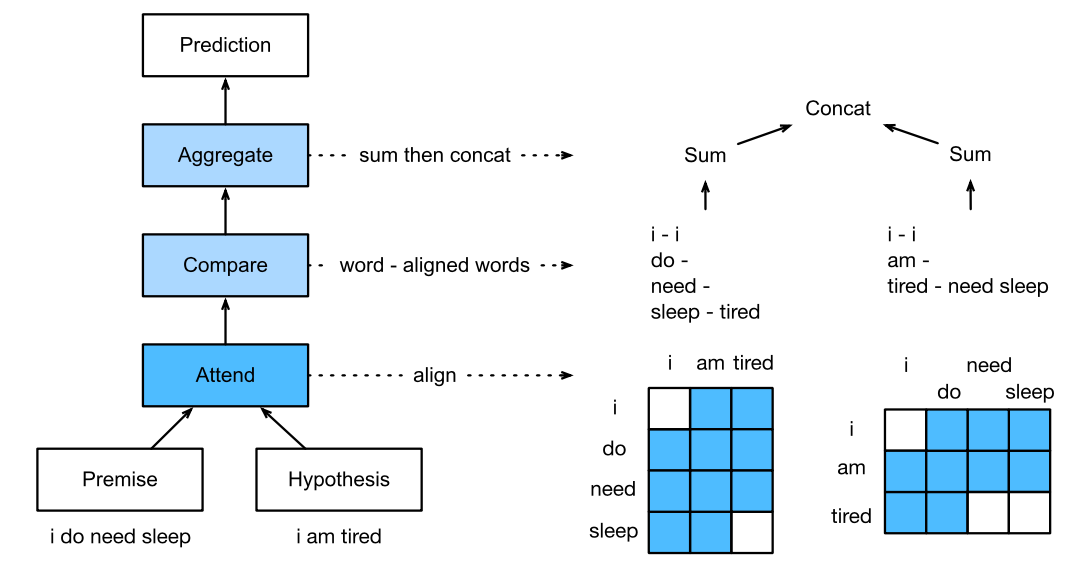

## Attending

The first step is to align tokens in one text sequence to each token in the other sequence. Suppose that the premise is “i do need sleep” and the hypothesis is “i am tired”. Due to semantical similarity, we may wish to align “i” in the hypothesis with “i” in the premise, and align “tired” in the hypothesis with “sleep” in the premise. Likewise, we may wish to align “i” in the premise with “i” in the hypothesis, and align “need” and “sleep” in the premise with “tired” in the hypothesis. Note that such alignment is soft using weighted average, where ideally large weights are associated with the tokens to be aligned.

Now we describe the soft alignment using attention mechanisms in more detail. Denote by premise_tokens = (a1, . . . , am) and hypothesis_tokens = (b1, . . . , bn) the premise and hypothesis, whose number of tokens are m and n, respectively, where ai,bj ∈ Rd (i = 1,...,m,j = 1,...,n) is a d-dimensional word vector. 

For soft alignment, we compute the attention weights eij ∈ R as
eij = f(ai).⊤ f(bj),  where the function f is an MLP defined in the following mlp function. The output dimension of f is specified by the num_hiddens argument of mlp.

It should be highlighted that f takes inputs ai and bj separately rather than takes a pair of them together as the input. This decomposition trick leads to only m + n applications (linear complexity) of f rather than mn applications (quadratic complexity).

In [21]:
def mlp(num_inputs, num_hiddens, flatten): 
  net = []
  net.append(nn.Dropout(0.2)) 
  net.append(nn.Linear(num_inputs, num_hiddens)) 
  net.append(nn.ReLU())
  
  if flatten:
    net.append(nn.Flatten(start_dim=1)) 
  
  net.append(nn.Dropout(0.2)) 
  net.append(nn.Linear(num_hiddens, num_hiddens)) 
  net.append(nn.ReLU())
  
  if flatten: 
    net.append(nn.Flatten(start_dim=1))
  
  return nn.Sequential(*net)

In [23]:
class Attend(nn.Module):
  def __init__(self, num_inputs, num_hiddens, **kwargs):
    super(Attend, self).__init__(**kwargs)
    self.f = mlp(num_inputs, num_hiddens, flatten=False)

  def forward(self, premises, hypotheses):
  # premises/hypothesis -> batch_size, len_premises/len_hypotheses, embed_dims
  # shape-> batch_size, len_premises/len_hypotheses, num_hiddens
    f_premises = self.f(premises)
    f_hypotheses = self.f(hypotheses)
    # e-> (`batch_size`, len_premises,len_hypotheses)
    e = torch.bmm(f_premises, f_hypotheses.permute(0, 2, 1))

    # (`batch_size`, len_premises,`embed_size`)
    aligned_hypotheses = torch.bmm(F.softmax(e, dim=-1), hypotheses)

    # (`batch_size`, len_hypotheses,`embed_size`)   
    aligned_premises = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), premises)
    
    return aligned_hypotheses, aligned_premises

## Comparing

In the next step, we compare a token in one sequence with the other sequence that is softly aligned with that token. Note that in soft alignment, all the tokens from one sequence, though with probably different attention weights, will be compared with a token in the other sequence. For example, suppose that the attending step determines that “need” and “sleep” in the premise are both aligned with “tired” in the hypothesis, the pair “tired–need sleep” will be compared.

In the comparing step, we feed the concatenation of tokens from one sequence and aligned tokens from the other sequence into a function g (an MLP)

In [25]:
class Compare(nn.Module):
  def __init__(self, num_inputs, num_hiddens, **kwargs):
    super(Compare, self).__init__(**kwargs)
    self.g = mlp(num_inputs, num_hiddens, flatten=False)

  def forward(self, premises, hypotheses, aligned_hypotheses, aligned_premises):
    #batch_size,len_premises,2*embed_size
    V_premises = self.g(torch.cat([premises, aligned_hypotheses], dim=2)) 
    #batch_size,len_hypotheses,2*embed_size
    V_hypotheses = self.g(torch.cat([hypotheses, aligned_premises], dim=2))

    return V_premises, V_hypotheses

## Aggregating

With two sets of comparison vectors V_premises,i (i = 1,...,m) and V_hypotheses,j (j = 1,...,n) on hand, in the last step we will aggregate such information to infer the logical relationship. We begin by summing up both sets:
Next we feed the concatenation of both summarization results into function h (an MLP) to obtain
the classification result of the logical relationship:
y = h([V_premises,V_hypotheses]).

In [26]:
class Aggregate(nn.Module):
  def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
    super(Aggregate, self).__init__(**kwargs)
    self.h = mlp(num_inputs, num_hiddens, flatten=True) 
    self.linear = nn.Linear(num_hiddens, num_outputs)

  def forward(self, V_premises, V_hypotheses):
    # Sum up both sets of comparison vectors
    #batch_size, embed_dim
    V_premises = V_premises.sum(dim=1)
    #batch_size, embed_dim
    V_hypotheses = V_hypotheses.sum(dim=1)
    # Feed the concatenation of both summarization results into an MLP 
    
    #batch_size,1,4*embed_dims -> batch_size,num_hiddens -> batch_size, num_outputs
    Y_hat = self.linear(self.h(torch.cat([V_premises, V_hypotheses], dim=1)))
    return Y_hat

## Putting Together

In [27]:
class DecomposableAttention(nn.Module):
  def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100,num_inputs_compare=200, num_inputs_agg=400, **kwargs): 
    super(DecomposableAttention, self).__init__(**kwargs) 
    self.embedding = nn.Embedding(len(vocab), embed_size)
    self.attend = Attend(num_inputs_attend, num_hiddens)
    self.compare = Compare(num_inputs_compare, num_hiddens)
    # There are 3 possible outputs: entailment, contradiction, and neutral 
    self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)

  def forward(self, X):
    premises, hypotheses = X
    #batch_size,len_premises,embed_dim
    premises_embedded = self.embedding(premises)
    #batch_size,len_hypotheses,embed_dim
    hypotheses_embedded = self.embedding(hypotheses)
    #batch_size,len_hypotheses/len_premises,embed_dim
    aligned_hypotheses, aligned_premises = self.attend(premises_embedded, hypotheses_embedded)
    #batch_size,len_hypotheses/len_premises,2*embed_dim
    V_premises, V_hypotheses = self.compare(premises_embedded, hypotheses_embedded, aligned_hypotheses, aligned_premises) 
    #batch_size,3
    Y_hat = self.aggregate(V_premises, V_hypotheses)
    return Y_hat


# Training

## Initiate with Glove and unfreeze embeddings

In [60]:
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus() 
net = DecomposableAttention(vocab, embed_size, num_hiddens) 
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token] 
net.embedding.weight.data.copy_(embeds);
summary(net)

Layer (type:depth-idx)                   Param #
DecomposableAttention                    --
├─Embedding: 1-1                         1,867,600
├─Attend: 1-2                            --
│    └─Sequential: 2-1                   --
│    │    └─Dropout: 3-1                 --
│    │    └─Linear: 3-2                  20,200
│    │    └─ReLU: 3-3                    --
│    │    └─Dropout: 3-4                 --
│    │    └─Linear: 3-5                  40,200
│    │    └─ReLU: 3-6                    --
├─Compare: 1-3                           --
│    └─Sequential: 2-2                   --
│    │    └─Dropout: 3-7                 --
│    │    └─Linear: 3-8                  40,200
│    │    └─ReLU: 3-9                    --
│    │    └─Dropout: 3-10                --
│    │    └─Linear: 3-11                 40,200
│    │    └─ReLU: 3-12                   --
├─Aggregate: 1-4                         --
│    └─Sequential: 2-3                   --
│    │    └─Dropout: 3-13                --
│   

In [48]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
  if isinstance(net, nn.Module):
    net.eval() # Set the model to evaluation mode 
    if not device:
      device = next(iter(net.parameters())).device 

  # No. of correct predictions, no. of predictions 
  metric = d2l.Accumulator(2)
  with torch.no_grad():
    for X, y in data_iter:
      X = [x.to(devices[0]) for x in X]
      y = y.to(device) 
      metric.add(d2l.accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]

def train_batch(net,X,y,loss,optimizer,devices):
  X = [x.to(devices[0]) for x in X]
  y = y.to(devices[0])
  net.train()
  optimizer.zero_grad()
  pred = net(X)
  l = loss(pred, y)
  l.sum().backward()
  optimizer.step()
  train_loss_sum = l.sum() 
  train_acc_sum = d2l.accuracy(pred, y) 
  return train_loss_sum, train_acc_sum

def train(net, train_iter, test_iter, loss, trainer, num_epochs,devices=d2l.try_all_gpus()):
  timer, num_batches = d2l.Timer(), len(train_iter)
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  for epoch in range(num_epochs):
    # Sum of training loss, sum of training accuracy, no. of examples, no. of predictions
    metric = d2l.Accumulator(4)
    for i, (features, labels) in enumerate(train_iter):
      timer.start()
      l,acc=train_batch(net,features,labels,loss,trainer,devices)
      metric.add(l, acc, labels.shape[0], labels.numel())
      timer.stop()
    test_acc = evaluate_accuracy_gpu(net, test_iter)
    print(f'epoch {epoch+1}: loss {metric[0] / metric[2]:.3f}, train acc 'f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}') 
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on 'f'{str(devices)}')

In [61]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")

In [62]:
train(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

epoch 1: loss 0.724, train acc 0.685, test acc 0.785
epoch 2: loss 0.569, train acc 0.772, test acc 0.805
epoch 3: loss 0.526, train acc 0.792, test acc 0.810
epoch 4: loss 0.502, train acc 0.802, test acc 0.817
epoch 5: loss 0.486, train acc 0.810, test acc 0.812
epoch 6: loss 0.473, train acc 0.815, test acc 0.821
epoch 7: loss 0.463, train acc 0.820, test acc 0.821
epoch 8: loss 0.454, train acc 0.824, test acc 0.822
epoch 9: loss 0.446, train acc 0.827, test acc 0.826
epoch 10: loss 0.440, train acc 0.829, test acc 0.825
11287.5 examples/sec on [device(type='cuda', index=0)]


### Predict

In [54]:
def predict_snli(net, vocab, premise, hypothesis):
  """Predict the logical relationship between the premise and hypothesis.""" 
  net.eval()
  premise = torch.tensor(vocab[nltk.tokenize.word_tokenize(premise)], device=d2l.try_gpu())
  hypothesis = torch.tensor(vocab[nltk.tokenize.word_tokenize(hypothesis)], device=d2l.try_gpu())
  label = torch.argmax(net([premise.reshape((1, -1)),hypothesis.reshape((1, -1))]), dim=1)
  return 'entailment' if label == 0 else 'contradiction' if label == 1 else 'neutral'

In [66]:
predict_snli(net, vocab, "He has gone out for a walk", "He is driving right now")

'contradiction'

In [67]:
predict_snli(net, vocab, "He has gone out for a walk", "He is ten years old")

'neutral'

In [70]:
predict_snli(net, vocab, "He has gone out for a walk", "He is not driving")

'entailment'

## Freeze embeddings


In [51]:
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus() 
net = DecomposableAttention(vocab, embed_size, num_hiddens) 
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token] 
net.embedding.weight.data.copy_(embeds);
net.embedding.weight.requires_grad = False
summary(net)

Layer (type:depth-idx)                   Param #
DecomposableAttention                    --
├─Embedding: 1-1                         (1,867,600)
├─Attend: 1-2                            --
│    └─Sequential: 2-1                   --
│    │    └─Dropout: 3-1                 --
│    │    └─Linear: 3-2                  20,200
│    │    └─ReLU: 3-3                    --
│    │    └─Dropout: 3-4                 --
│    │    └─Linear: 3-5                  40,200
│    │    └─ReLU: 3-6                    --
├─Compare: 1-3                           --
│    └─Sequential: 2-2                   --
│    │    └─Dropout: 3-7                 --
│    │    └─Linear: 3-8                  40,200
│    │    └─ReLU: 3-9                    --
│    │    └─Dropout: 3-10                --
│    │    └─Linear: 3-11                 40,200
│    │    └─ReLU: 3-12                   --
├─Aggregate: 1-4                         --
│    └─Sequential: 2-3                   --
│    │    └─Dropout: 3-13                --
│ 

In [52]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")

In [53]:
train(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

epoch 1: loss 0.795, train acc 0.646, test acc 0.742
epoch 2: loss 0.681, train acc 0.717, test acc 0.766
epoch 3: loss 0.654, train acc 0.730, test acc 0.771
epoch 4: loss 0.641, train acc 0.737, test acc 0.776
epoch 5: loss 0.633, train acc 0.741, test acc 0.779
epoch 6: loss 0.625, train acc 0.744, test acc 0.780
epoch 7: loss 0.619, train acc 0.747, test acc 0.781
epoch 8: loss 0.615, train acc 0.749, test acc 0.782
epoch 9: loss 0.612, train acc 0.750, test acc 0.790
epoch 10: loss 0.610, train acc 0.751, test acc 0.794
14054.4 examples/sec on [device(type='cuda', index=0)]
